In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip


In [3]:
import numpy as np
import os
import shutil
from glob import glob
from PIL import Image
from tqdm import tqdm
import zipfile
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import  ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as Func

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
path_to_zip_file = "/kaggle/input/carvana-image-masking-challenge/train.zip"
save_directory = "/kaggle/working/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(save_directory)
    
path_to_zip_file = "/kaggle/input/carvana-image-masking-challenge/train_masks.zip"
save_directory = "/kaggle/working/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(save_directory)

In [5]:
os.mkdir('/kaggle/working/validation')
os.mkdir('/kaggle/working/validation_masks')
os.mkdir('/kaggle/working/saved_images')

In [6]:
for file in sorted(os.listdir('/kaggle/working/train'))[:1526]:
    shutil.move('/kaggle/working/train/' + file, '/kaggle/working/validation')

for file in sorted(os.listdir('/kaggle/working/train_masks'))[:1526]:
    shutil.move('/kaggle/working/train_masks/' + file, '/kaggle/working/validation_masks')

In [7]:
TRAIN_DIR = '/kaggle/working/train'
TRAIN_MASK_DIR = '/kaggle/working/train_masks'
VALIDATION_DIR = '/kaggle/working/validation'
VALIDATION_MASK_DIR = '/kaggle/working/validation_masks'
PRED_MASK_DIR = 'saved_images'

In [8]:
print("Training set:  ", len(os.listdir("/kaggle/working/train")))
print("Training masks:", len(os.listdir("/kaggle/working/train_masks")))
print("Validation set:  ", len(os.listdir("/kaggle/working/validation")))
print("Validation masks:", len(os.listdir("/kaggle/working/validation_masks")))

Training set:   3562
Training masks: 3562
Validation set:   1526
Validation masks: 1526


In [9]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = False

In [10]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None):
        self.image_dir = image_dir
        self.mask_dir  = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index]).replace(".jpg", "_mask.gif")
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [11]:
class ConvModel(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True))

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(ConvModel(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2,
                                               feature,
                                               kernel_size = 2,
                                               stride = 2))

            self.ups.append(ConvModel(feature*2, feature))

            self.bottleneck = ConvModel(features[-1], features[-1] * 2)

            self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for index in range(0, len(self.ups), 2):
            x = self.ups[index](x)
            skip_connection = skip_connections[index // 2]
            if x.shape != skip_connection.shape:
                x = Func.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[index + 1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.rand((3, 1, 161, 161))
    model = UNET(in_channels = 1, out_channels = 1)
    prediction = model(x)
    print(prediction.shape)
    print(x.shape)
    assert prediction.shape == x.shape


if __name__ == '__main__':
    test()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


In [12]:
def save_checkpoint(state, filename = "model_checkpoint.pth.tar"):
    print("Saving Checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("\nLoading Checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir,
                train_maskdir,
                val_dir,
                val_maskdir,
                batch_size,
                train_transform,
                val_transform,
                num_workers = 4,
                pin_memory = True):
    train_set = ImageDataset(image_dir = train_dir,
                            mask_dir = train_maskdir,
                            transform = train_transform)

    train_loader = DataLoader(train_set,
                              batch_size = batch_size,
                              num_workers = num_workers,
                              pin_memory = pin_memory,
                              shuffle = True)

    val_set = ImageDataset(image_dir = val_dir,
                            mask_dir = val_maskdir,
                            transform = val_transform)

    val_loader = DataLoader(val_set,
                            batch_size = batch_size,
                            num_workers = num_workers,
                            pin_memory = pin_memory,
                            shuffle = False)

    return train_loader, val_loader

def check_accuracy(loader, model, device = "cuda"):
    correct_pixels = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            prediction = torch.sigmoid(model(x))
            prediction = (prediction > 0.5).float()
            correct_pixels += (prediction == y).sum()
            num_pixels += torch.numel(prediction)

        print(f"Accuracy: {correct_pixels / num_pixels * 100:.2f}")

        model.train()


def save_predictions(loader, model, folder = "saved_images/", device = "cuda"):
    model.eval()
    for index, (x, y) in enumerate(loader):
        x = x.to(device = device)
        with torch.no_grad():
            prediction = torch.sigmoid(model(x))
            prediction = (prediction > 0.5).float()
        torchvision.utils.save_image(prediction, f"{folder}/prediction_{index}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{index}.png")

    torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{index}.png")

In [13]:
def train_func(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_index, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.float().unsqueeze(1).to(device = DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss = loss.item())


def main():
    train_transform = A.Compose(
        [A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
         A.Rotate(limit = 35, p = 1.0),
         A.HorizontalFlip(p = 0.5),
         A.VerticalFlip(p = 0.1),
         A.Normalize(mean = [0.0, 0.0, 0.0],
                     std = [1.0, 1.0, 1.0],
                     max_pixel_value = 255.0),
         ToTensorV2(),])

    validation_transform = A.Compose(
        [A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
         A.Normalize(mean = [0.0, 0.0, 0.0],
                     std = [1.0, 1.0, 1.0],
                     max_pixel_value = 255.0),
         ToTensorV2(),])

    model = UNET(in_channels = 3, out_channels = 1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

    train_loader, val_loader = get_loaders(TRAIN_DIR,
                                           TRAIN_MASK_DIR,
                                           VALIDATION_DIR,
                                           VALIDATION_MASK_DIR,
                                           BATCH_SIZE,
                                           train_transform,
                                           validation_transform,
                                           NUM_WORKERS,
                                           PIN_MEMORY)

    if LOAD_MODEL:
        load_checkpoint(torch.load("model_checkpoint.pth.tar"), model)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        train_func(train_loader, model, optimizer, loss_fn, scaler)

        checkpoint = {"state_dict": model.state_dict(),
                      "optimizer":optimizer.state_dict()}
        save_checkpoint(checkpoint)

        check_accuracy(val_loader, model, device = DEVICE)

        save_predictions(val_loader, model, folder = "saved_images/", device = DEVICE)

if __name__ == "__main__":
    main()

100%|██████████| 223/223 [01:33<00:00,  2.38it/s, loss=0.186]


Saving Checkpoint
Accuracy: 99.00


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.059] 


Saving Checkpoint
Accuracy: 97.70


100%|██████████| 223/223 [01:26<00:00,  2.58it/s, loss=0.0397]


Saving Checkpoint
Accuracy: 97.57


100%|██████████| 223/223 [01:26<00:00,  2.58it/s, loss=0.0291]


Saving Checkpoint
Accuracy: 98.64


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0267]


Saving Checkpoint
Accuracy: 97.44


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0306]


Saving Checkpoint
Accuracy: 98.26


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0197]


Saving Checkpoint
Accuracy: 98.76


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0242]


Saving Checkpoint
Accuracy: 98.32


100%|██████████| 223/223 [01:26<00:00,  2.58it/s, loss=0.0169]


Saving Checkpoint
Accuracy: 99.08


100%|██████████| 223/223 [01:26<00:00,  2.58it/s, loss=0.0178]


Saving Checkpoint
Accuracy: 99.04


In [14]:
LOAD_MODEL = True

In [15]:
def train_func(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_index, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device = DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss = loss.item())


def main():
    train_transform = A.Compose(
        [A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
         A.Rotate(limit = 35, p = 1.0),
         A.HorizontalFlip(p = 0.5),
         A.VerticalFlip(p = 0.1),
         A.Normalize(mean = [0.0, 0.0, 0.0],
                     std = [1.0, 1.0, 1.0],
                     max_pixel_value = 255.0),
         ToTensorV2(),])

    validation_transform = A.Compose(
        [A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
         A.Normalize(mean = [0.0, 0.0, 0.0],
                     std = [1.0, 1.0, 1.0],
                     max_pixel_value = 255.0),
         ToTensorV2(),])

    model = UNET(in_channels = 3, out_channels = 1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

    train_loader, val_loader = get_loaders(TRAIN_DIR,
                                           TRAIN_MASK_DIR,
                                           VALIDATION_DIR,
                                           VALIDATION_MASK_DIR,
                                           BATCH_SIZE,
                                           train_transform,
                                           validation_transform,
                                           NUM_WORKERS,
                                           PIN_MEMORY)

    if LOAD_MODEL:
        load_checkpoint(torch.load("model_checkpoint.pth.tar"), model)

    check_accuracy(val_loader, model, device = DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(EPOCHS):
        train_func(train_loader, model, optimizer, loss_fn, scaler)

        checkpoint = {"state_dict": model.state_dict(),
                      "optimizer":optimizer.state_dict()}
        save_checkpoint(checkpoint)

        check_accuracy(val_loader, model, device = DEVICE)

        save_predictions(val_loader, model, folder = "saved_images/", device = DEVICE)

if __name__ == "__main__":
    main()


Loading Checkpoint
Accuracy: 99.04


100%|██████████| 223/223 [01:27<00:00,  2.54it/s, loss=0.126]


Saving Checkpoint
Accuracy: 99.11


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0381]


Saving Checkpoint
Accuracy: 98.46


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0332]


Saving Checkpoint
Accuracy: 98.67


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0233]


Saving Checkpoint
Accuracy: 99.08


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.019] 


Saving Checkpoint
Accuracy: 99.09


100%|██████████| 223/223 [01:27<00:00,  2.56it/s, loss=0.0168]


Saving Checkpoint
Accuracy: 99.26


100%|██████████| 223/223 [01:27<00:00,  2.56it/s, loss=0.015] 


Saving Checkpoint
Accuracy: 99.36


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0135]


Saving Checkpoint
Accuracy: 99.24


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0148]


Saving Checkpoint
Accuracy: 99.30


100%|██████████| 223/223 [01:26<00:00,  2.57it/s, loss=0.0263]


Saving Checkpoint
Accuracy: 99.04


In [ ]:
#model = torch.load('model_checkpoint.pth.tar')

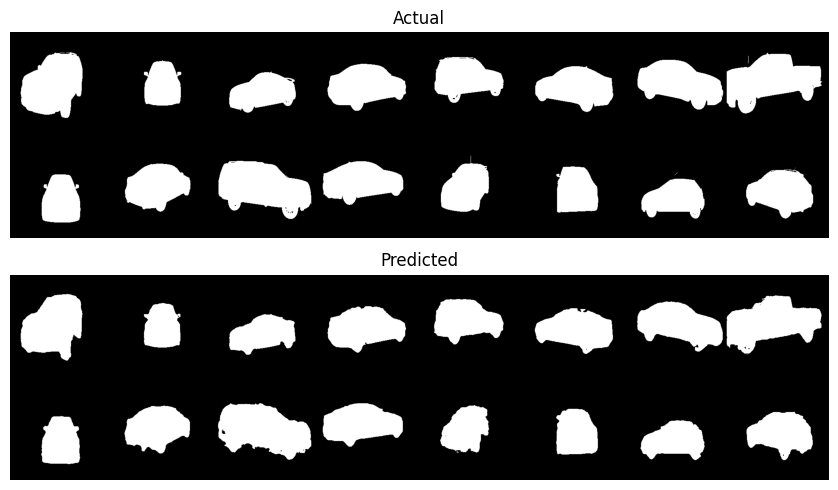

In [38]:
# Specify the filenames of the two images you want to display
image_filenames = ["64.png", "prediction_64.png"]
image_path = 'saved_images'

# Load and display the selected images
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
for i, filename in enumerate(image_filenames):
    image = Image.open(os.path.join("saved_images", filename))
    axes[i].imshow(image)
    axes[i].set_title("Actual" if "prediction" not in filename else "Predicted") 
    axes[i].axison = False

plt.tight_layout()
#plt.axis('off')
plt.show()

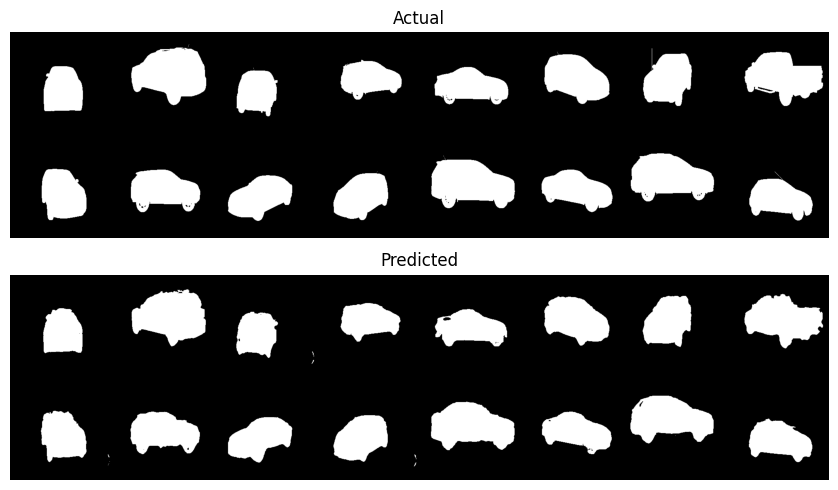

In [39]:
image_filenames = ["3.png", "prediction_3.png"]

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
for i, filename in enumerate(image_filenames):
    image = Image.open(os.path.join("saved_images", filename))
    axes[i].imshow(image)
    axes[i].set_title("Actual" if "prediction" not in filename else "Predicted") 
    axes[i].axison = False

plt.tight_layout()
#plt.axis('off')
plt.show()

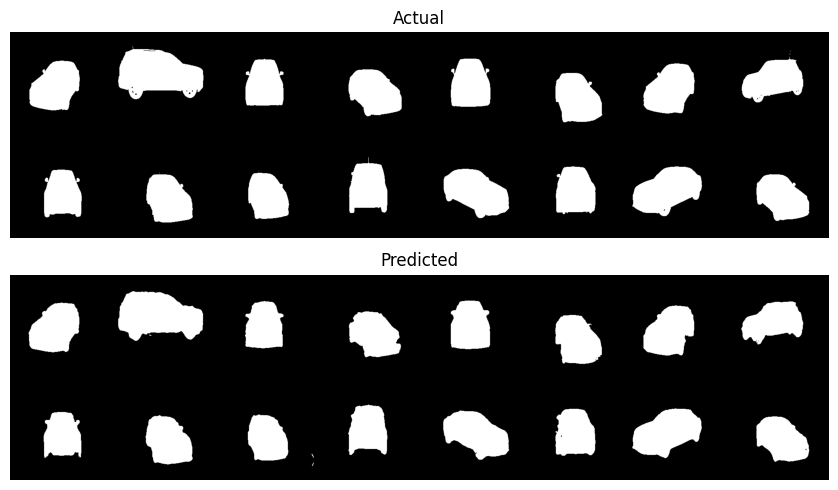

In [40]:
image_filenames = ["72.png", "prediction_72.png"]

fig, axes = plt.subplots(2, 1, figsize=(10, 5))
for i, filename in enumerate(image_filenames):
    image = Image.open(os.path.join("saved_images", filename))
    axes[i].imshow(image)
    axes[i].set_title("Actual" if "prediction" not in filename else "Predicted") 
    axes[i].axison = False

plt.tight_layout()
#plt.axis('off')
plt.show()